# 2.6 Global Volume / Dollar Bars

In the text "Advances in Financial Machine Learning", author Marcos Lopez de Prado introduces the idea of information driven bars. He shows that bars with the basis of time as a discrete unit to not produce gaussian returns. However, bars with units of Volume do show guassian returns. Because of this, machine learning may struggle to find relationships in time bars, but might do significantly better with volume bars. 

De Prado goes further to discuss Dollar Bars, where the volume of a security is multiplied by the value of the underlying to produce a quantification of the amount of actual value being exchanged. I will investigate this kind of bar in this notebook, and attempt to apply it on a global-market scale. For now, "Global" will be defined as the SP500 index of stocks. However, in the future I will strive to define "Global" as truly global. The end goal will encompass the highest market cap stocks on exchanges around the world, currencies, and commodities. 

The goal of this kind of modeling is indeed to produce a model that traces the movement of all value globally. Of course, I cannot model every single instrument, so I will limit my pursuit to only those instruments that represent a large relative portion of trading value on a single day. 

In this notebook, we will look at the SP500 as a limited scope. We will seek to answer the questions:

- How much total value is traded on a single day in the SP500? 
- What is a good quantization of this value for a single bar?
- How can we transform the underlying time bars to represent dollar bars? 
- Once the transformation is complete, can we find any correlations in the market data? 

#### Extract SP500 Market Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sp = pd.read_csv('../data/S&P500-Symbols.csv').drop('Unnamed: 0', axis=1)
sp.head()

,Symbol
0,MMM
1,ABT
2,ABBV
3,ABMD
4,ACN


In [2]:
df = pd.read_csv('../data/sp500/sp500_minute_data.csv')
df.head()

,datetime,MMM_open,MMM_high,MMM_low,MMM_close,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,...,ZION_open,ZION_high,ZION_low,ZION_close,ZION_volume,ZTS_open,ZTS_high,ZTS_low,ZTS_close,ZTS_volume
0,2020-08-17 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-17 08:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-17 08:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-17 08:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-17 08:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(19729, 2526)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [5]:
df.loc[:, df.columns[df.columns.str.contains('volume')]] = df.loc[:, df.columns[df.columns.str.contains('volume')]].fillna(0)

In [6]:
df.loc[:, df.columns[~df.columns.str.contains('volume')]] = df.loc[:, df.columns[~df.columns.str.contains('volume')]].fillna(method='ffill')

In [7]:
df.tail(100)

,MMM_open,MMM_high,MMM_low,MMM_close,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,ABT_volume,...,ZION_open,ZION_high,ZION_low,ZION_close,ZION_volume,ZTS_open,ZTS_high,ZTS_low,ZTS_close,ZTS_volume
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-15 18:52:00,166.6200,166.7000,166.62,166.70,825.0,106.755,106.7700,106.740,106.7400,2008.0,...,31.4000,31.4200,31.4000,31.4200,1100.0,162.415,162.49,162.410,162.430,3006.0
2020-09-15 18:53:00,166.7017,166.7114,166.67,166.67,1953.0,106.745,106.7600,106.740,106.7400,1944.0,...,31.4150,31.4150,31.4050,31.4100,900.0,162.430,162.46,162.387,162.415,2448.0
2020-09-15 18:54:00,166.6600,166.6600,166.65,166.66,801.0,106.750,106.7826,106.745,106.7826,1613.0,...,31.4000,31.4000,31.3700,31.3700,1000.0,162.450,162.48,162.420,162.480,1000.0
2020-09-15 18:55:00,166.6300,166.6387,166.59,166.59,613.0,106.810,106.8200,106.780,106.7800,3422.0,...,31.3700,31.3800,31.3700,31.3800,929.0,162.480,162.56,162.480,162.510,2400.0
2020-09-15 18:56:00,166.5700,166.5700,166.53,166.54,2198.0,106.780,106.8282,106.780,106.8242,1550.0,...,31.3800,31.3850,31.3400,31.3850,6955.0,162.510,162.53,162.450,162.530,2563.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15 20:27:00,166.5000,166.5000,166.50,166.50,0.0,106.580,106.5800,106.580,106.5800,0.0,...,31.4029,31.4029,31.4029,31.4029,0.0,162.280,162.28,162.280,162.280,3951.0
2020-09-15 20:28:00,166.5000,166.5000,166.50,166.50,0.0,106.580,106.5800,106.580,106.5800,0.0,...,31.4029,31.4029,31.4029,31.4029,0.0,162.280,162.28,162.280,162.280,0.0
2020-09-15 20:29:00,166.5000,166.5000,166.50,166.50,0.0,106.580,106.5800,106.580,106.5800,0.0,...,31.4029,31.4029,31.4029,31.4029,0.0,162.280,162.28,162.280,162.280,0.0


In [8]:
#### Consider only volume

vol_df = df[df.columns[df.columns.str.contains('volume')]]

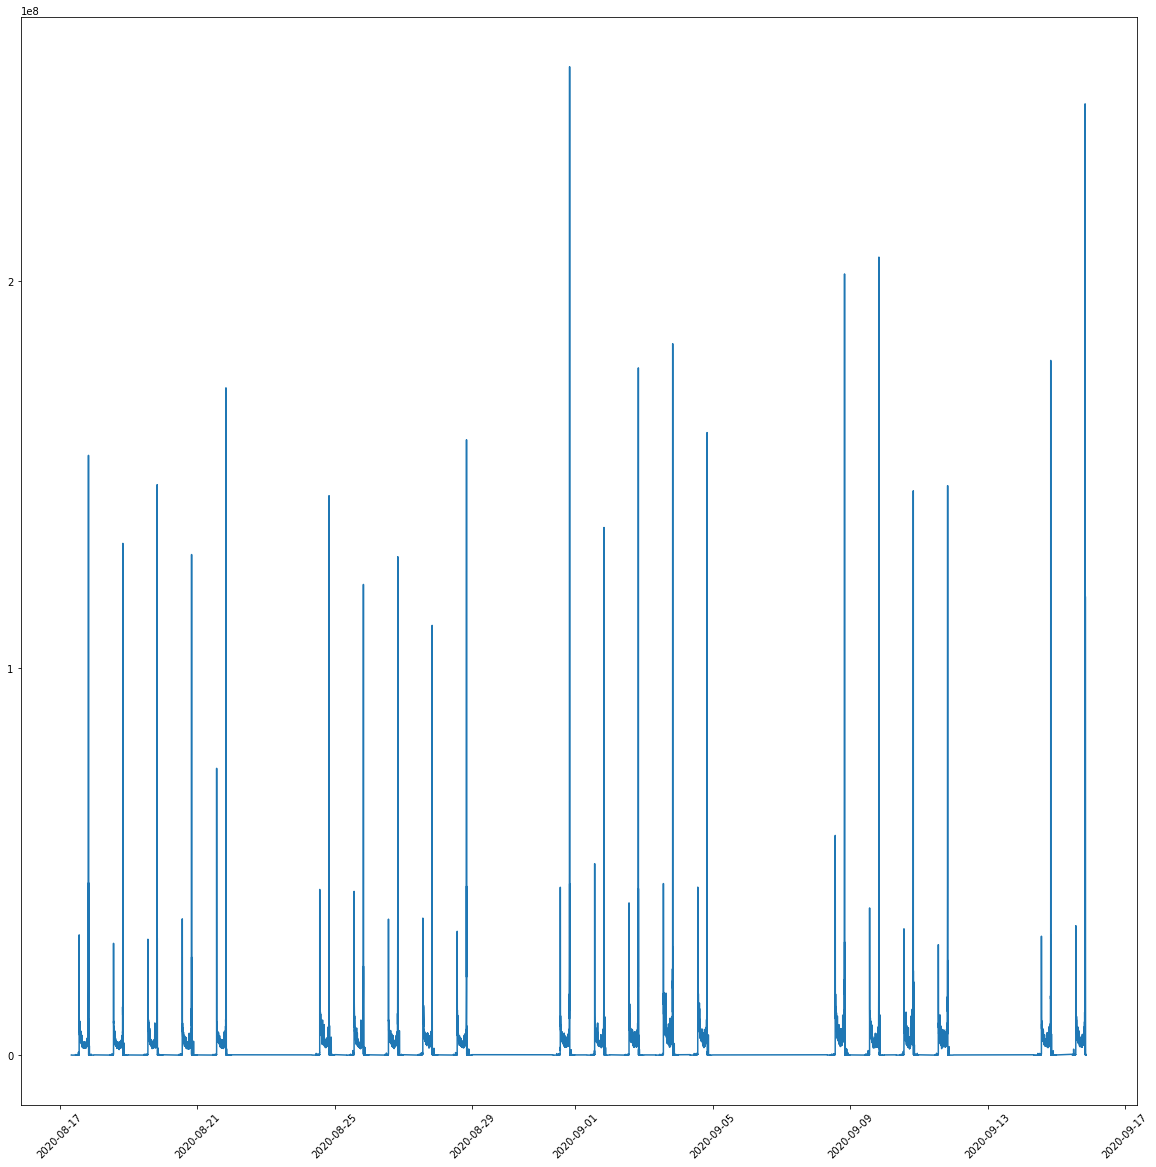

In [9]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df.sum(axis=1))

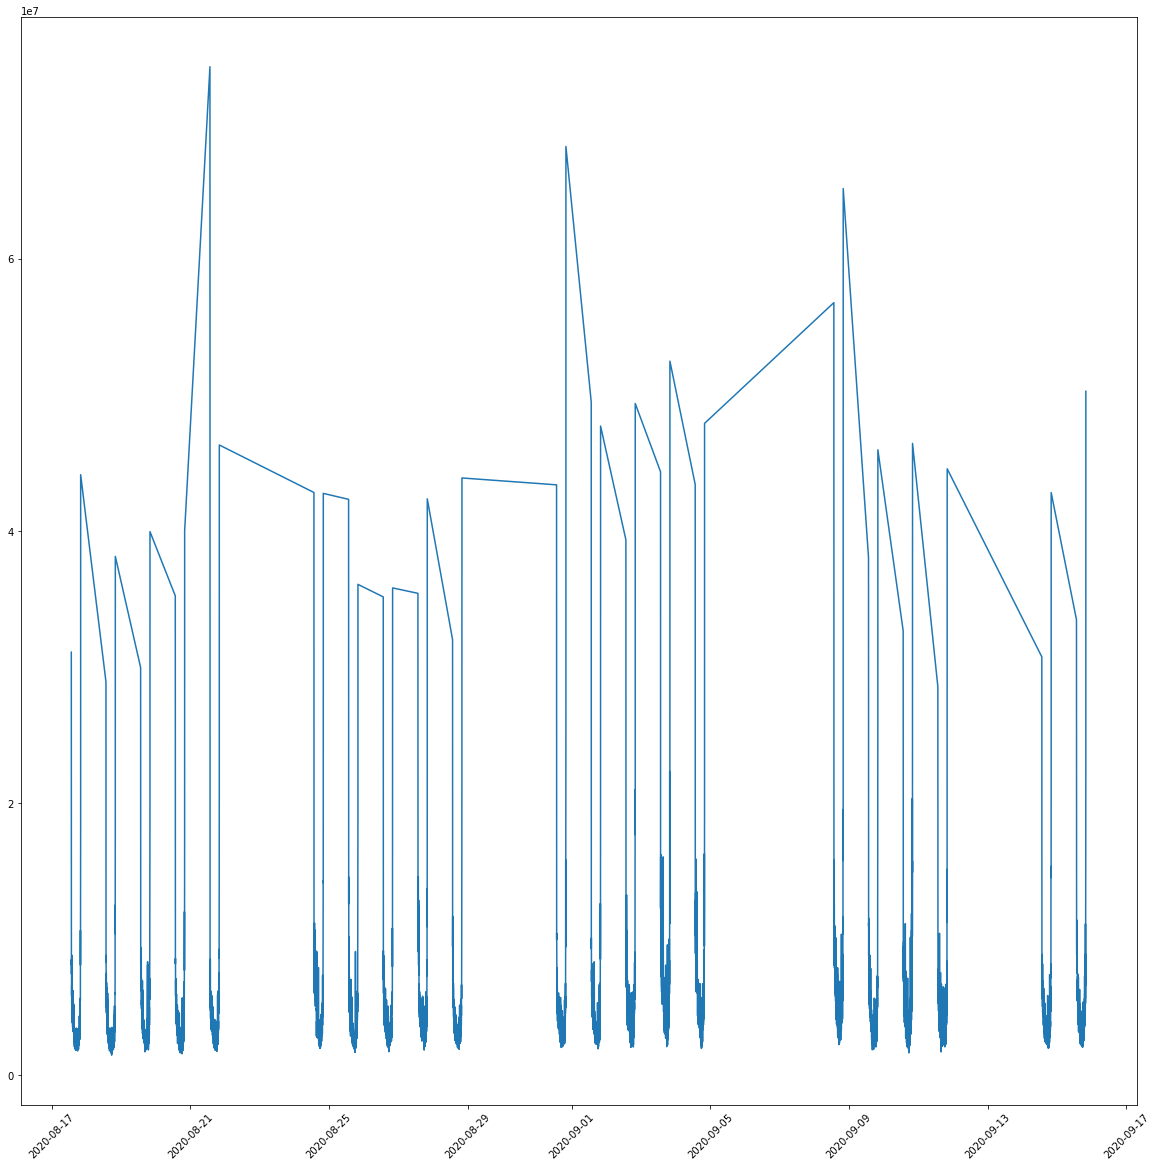

In [10]:
h13 = vol_df.index.hour > 13
h20 = vol_df.index.hour < 20
m30 = vol_df.index.minute >= 30
h12 = vol_df.index.hour > 12

plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df[h20 & (h13 | (h12 & m30))].sum(axis=1))

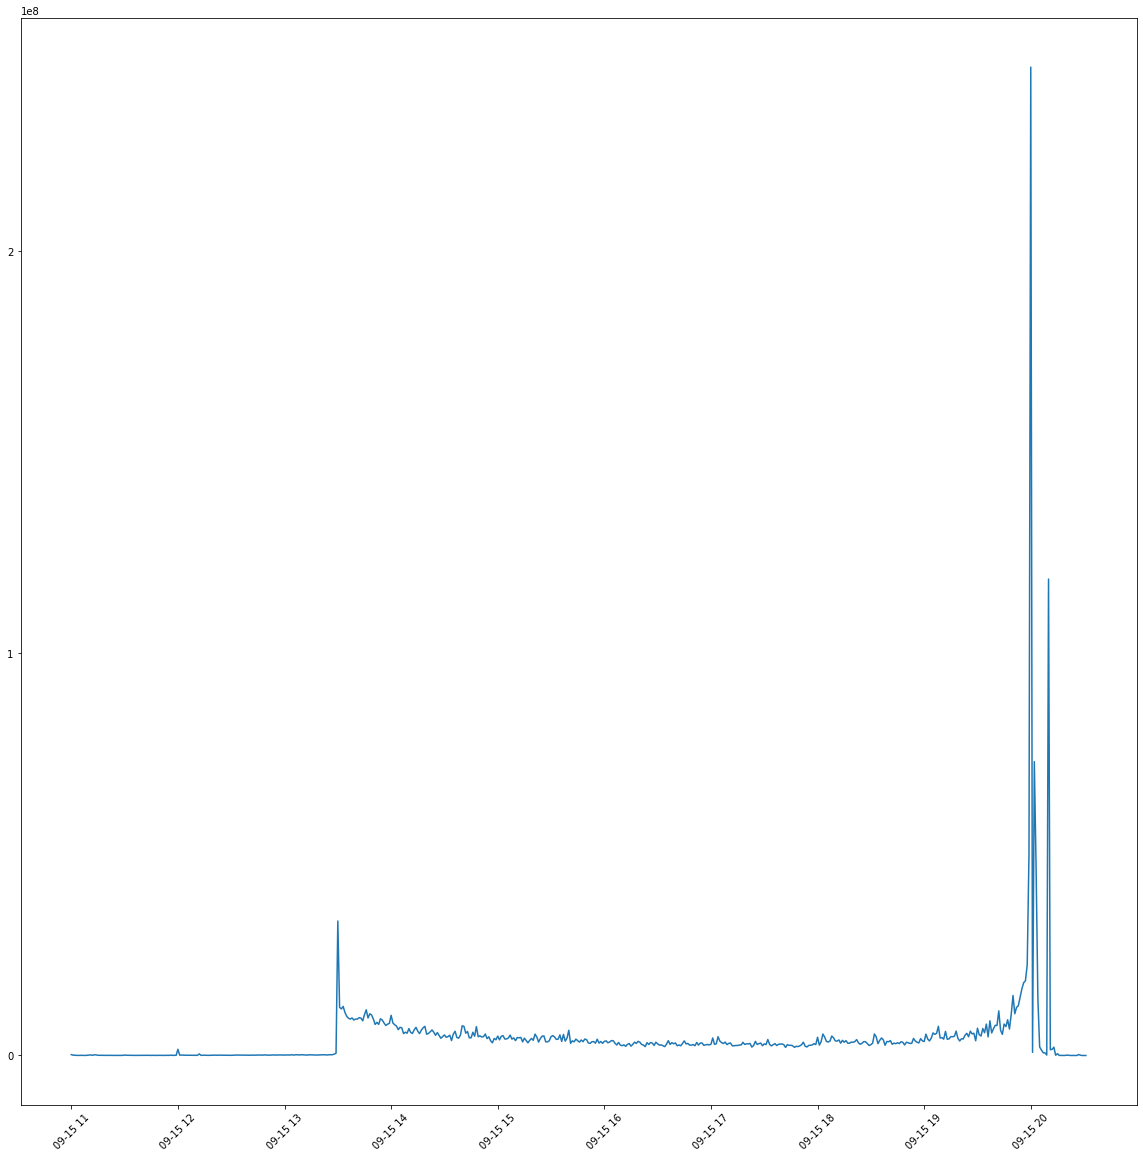

In [11]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df[vol_df.index.day == 15].sum(axis=1))

Surprisingly, the largest amount of volume consistently happens in the afternoon posterior to market close. There is also a large spike every day on market open. 

In considering what to do with volume after market close, we need to be mindful of two aspects. First, can we trade while the market is closed? Second, do after hours trades affect the price of instruments?

Unfortunately, the answer to the first question is no while the answer to the second question is definitely yes. Because the answer to the second question is yes, we must leave this data in the model. Unfortunately, we will not currently be able to make use of it. 

On the other hand, because we will group time by dollar volume, we do not need to worry about the long periods of zero volume. They should disappear naturally once we change the encoding. 

In [12]:
vol_df.sum(axis=1).describe()

count    1.972900e+04
mean     2.230566e+06
std      6.609704e+06
min      1.000000e+02
25%      1.525600e+04
50%      8.586700e+04
75%      3.301421e+06
max      2.553862e+08
dtype: float64

In [13]:
vol_df.sum(axis=1)

datetime
2020-08-17 08:00:00     27994.0
2020-08-17 08:01:00     11425.0
2020-08-17 08:02:00      4973.0
2020-08-17 08:03:00      9992.0
2020-08-17 08:04:00     17819.0
                         ...   
2020-09-15 20:27:00    247822.0
2020-09-15 20:28:00     54176.0
2020-09-15 20:29:00      2273.0
2020-09-15 20:30:00     15016.0
2020-09-15 20:31:00       145.0
Length: 19729, dtype: float64

In [14]:
1e4

10000.0

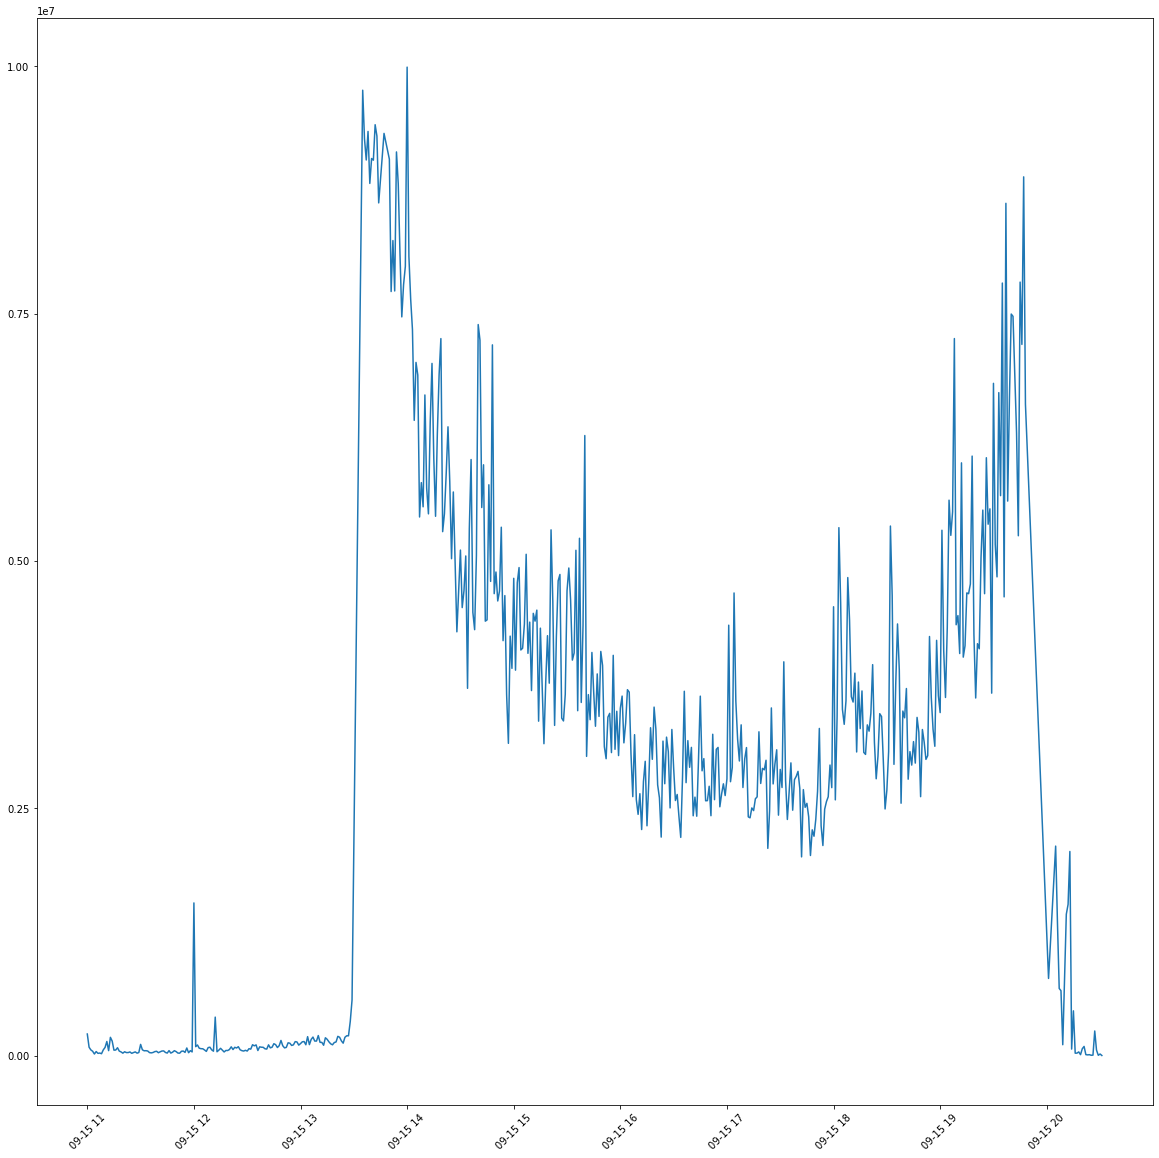

In [15]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(vol_df[(vol_df.sum(axis=1) < 1e7) & (vol_df.index.day == 15)].sum(axis=1))

Challenge: write an algorithm that changes time bars to volume and/or dollar bars 

First, we have only looked at volume so far. What if we look at daily value exchanged by minute? 

In [16]:
for sym in sp['Symbol']:
    df[f'{sym}_value_close'] = df[f'{sym}_volume'] * df[f'{sym}_close']

cols = df.columns.str.contains('_value_close')
cols

array([False, False, False, ...,  True,  True,  True])

In [17]:
df[df.columns[cols]].sum(axis=1)

datetime
2020-08-17 08:00:00    1.804312e+06
2020-08-17 08:01:00    4.433228e+05
2020-08-17 08:02:00    3.494197e+05
2020-08-17 08:03:00    2.974451e+05
2020-08-17 08:04:00    1.003737e+06
                           ...     
2020-09-15 20:27:00    2.167994e+07
2020-09-15 20:28:00    5.310754e+06
2020-09-15 20:29:00    2.603237e+05
2020-09-15 20:30:00    1.181363e+06
2020-09-15 20:31:00    1.415153e+04
Length: 19729, dtype: float64

In [18]:
df.columns[cols]

Index(['MMM_value_close', 'ABT_value_close', 'ABBV_value_close',
       'ABMD_value_close', 'ACN_value_close', 'ATVI_value_close',
       'ADBE_value_close', 'AMD_value_close', 'AAP_value_close',
       'AES_value_close',
       ...
       'WYNN_value_close', 'XEL_value_close', 'XRX_value_close',
       'XLNX_value_close', 'XYL_value_close', 'YUM_value_close',
       'ZBRA_value_close', 'ZBH_value_close', 'ZION_value_close',
       'ZTS_value_close'],
      dtype='object', length=505)

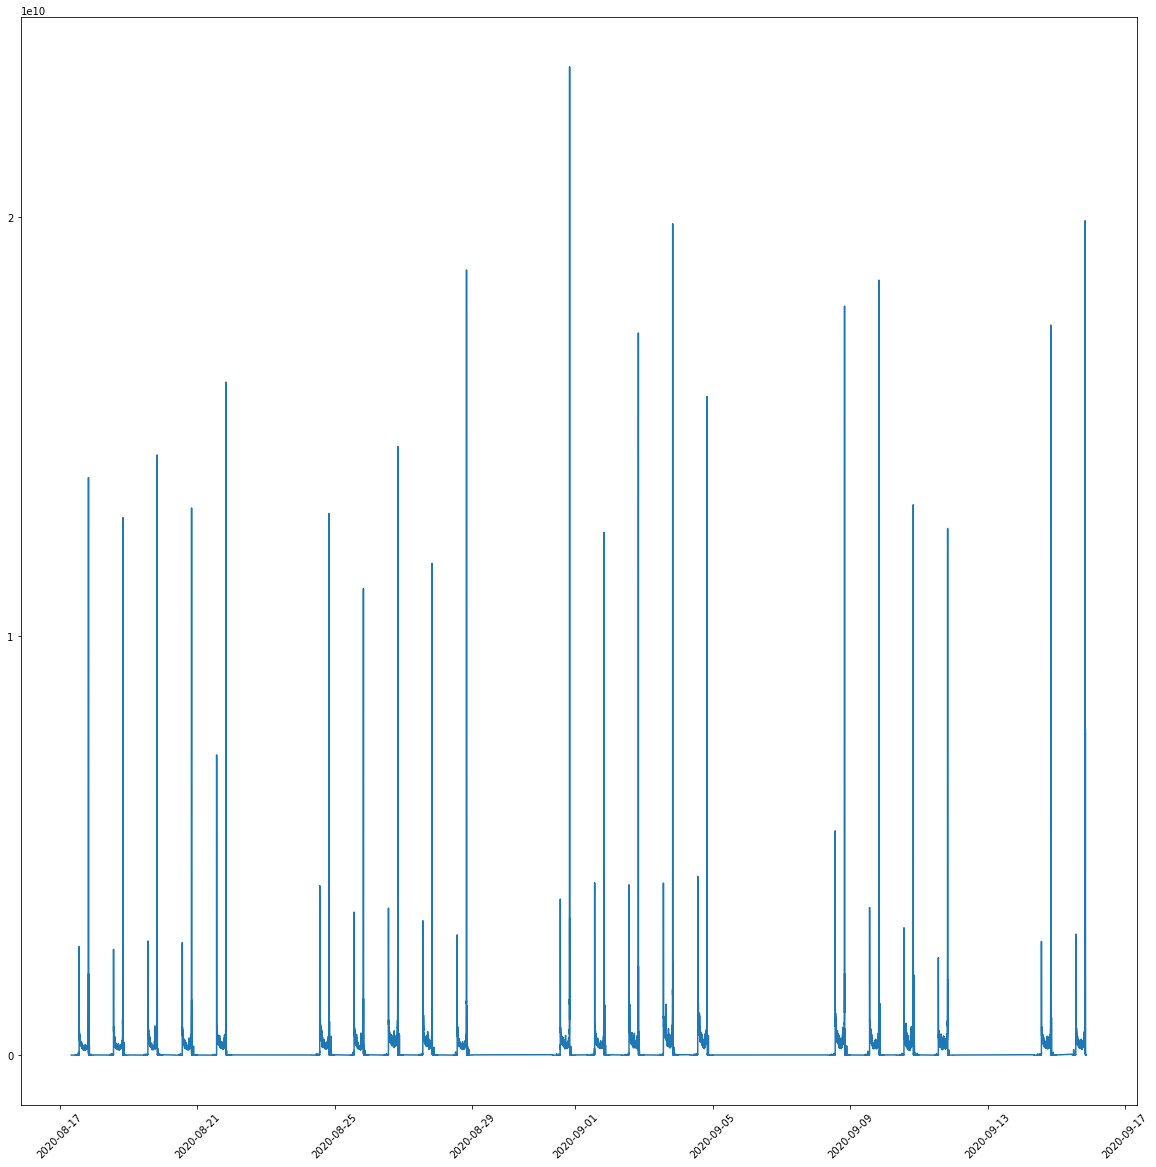

In [19]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(df[df.columns[cols]].sum(axis=1))

In [20]:
value_df = df[df.columns[cols]].sum(axis=1)
value_df.shape

(19729,)

In [21]:
value_df[value_df.index.day == 15]

datetime
2020-09-15 11:00:00    2.130321e+07
2020-09-15 11:01:00    1.078915e+07
2020-09-15 11:02:00    8.597688e+06
2020-09-15 11:03:00    7.684807e+06
2020-09-15 11:04:00    2.712824e+06
                           ...     
2020-09-15 20:27:00    2.167994e+07
2020-09-15 20:28:00    5.310754e+06
2020-09-15 20:29:00    2.603237e+05
2020-09-15 20:30:00    1.181363e+06
2020-09-15 20:31:00    1.415153e+04
Length: 572, dtype: float64

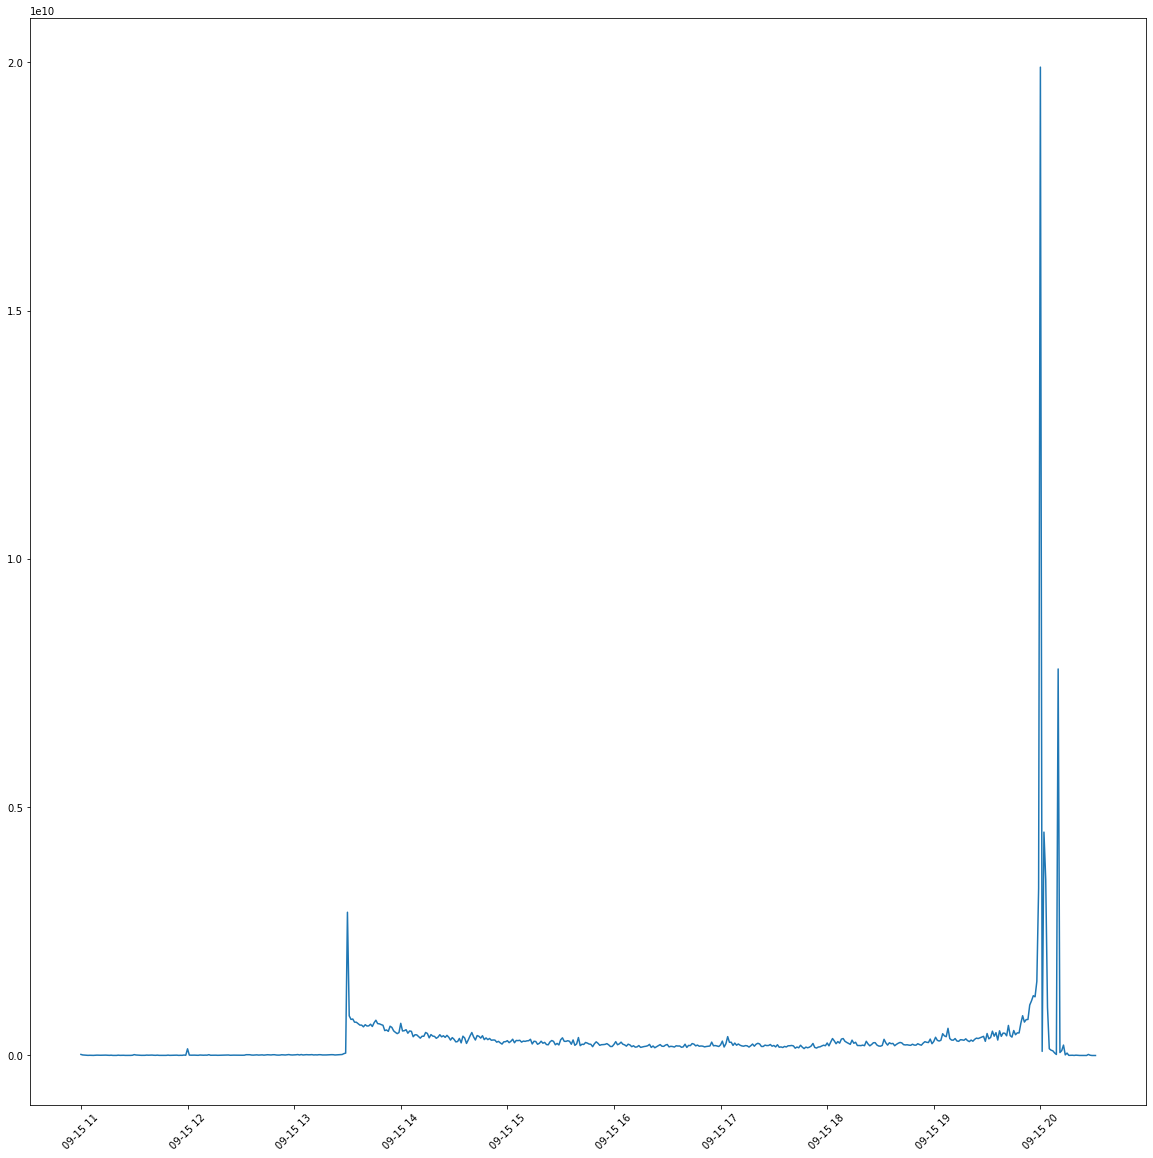

In [22]:
plt.figure(figsize=(20,20))
plt.locator_params(nbins=5)
plt.xticks(rotation=45)
plt.plot(value_df[value_df.index.day == 15])

In [23]:
value_df.describe()

count    1.972900e+04
mean     1.676852e+08
std      5.849448e+08
min      6.080000e+02
25%      1.173722e+06
50%      7.468689e+06
75%      2.437587e+08
max      2.357890e+10
dtype: float64

Text(0.5, 0, 'Value traded per minute, Billions $')

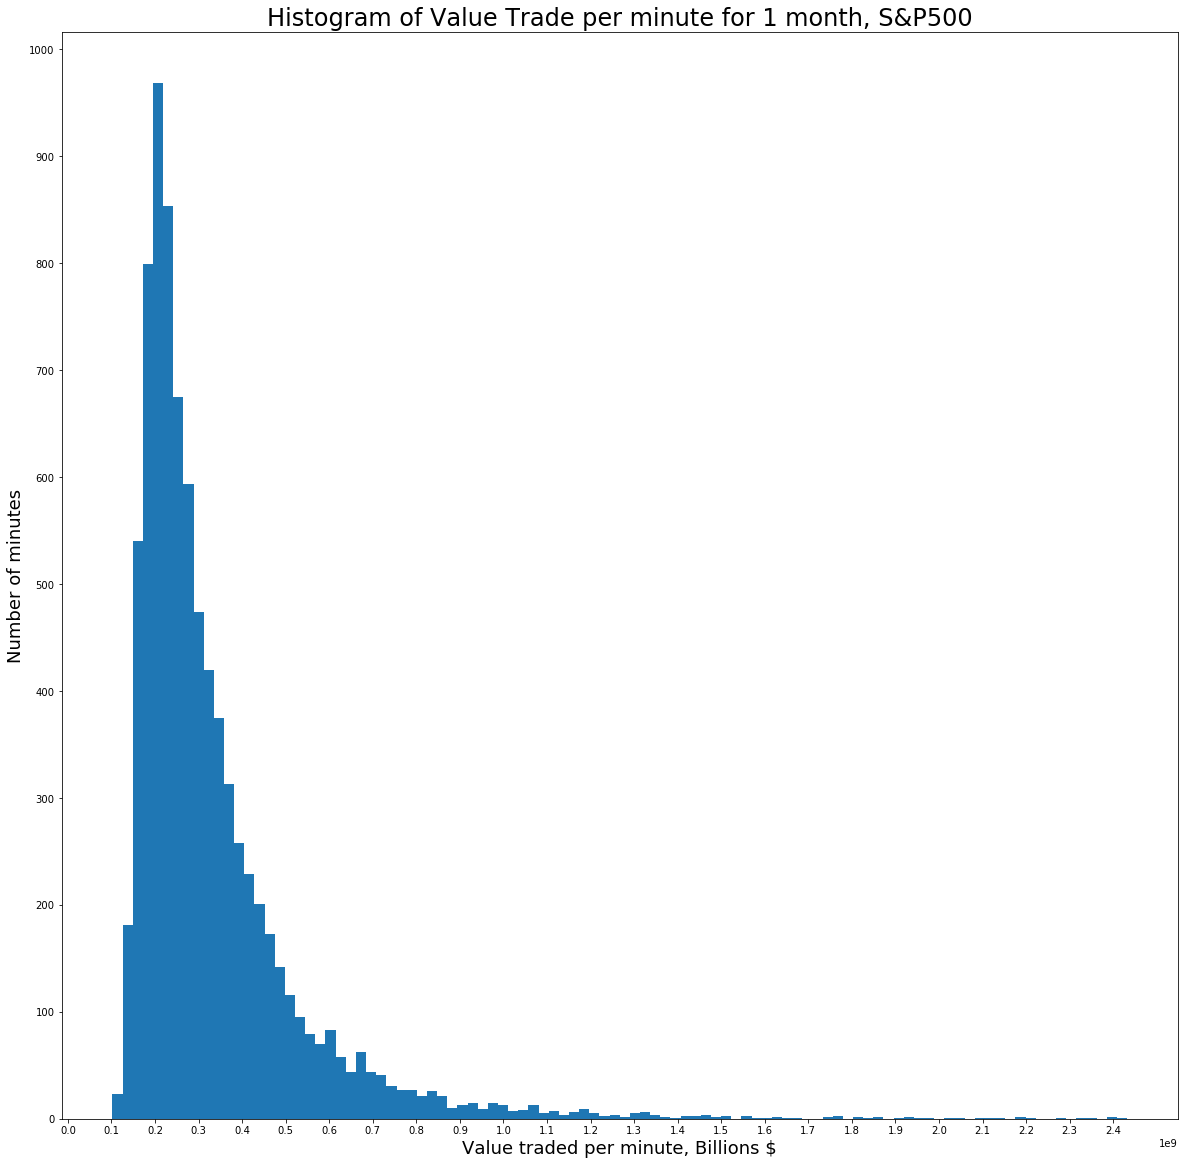

In [24]:
plt.figure(figsize=(20,20))
plt.xticks(np.arange(0, .25e10, step=.01e10))
plt.yticks(np.arange(0,12000, step=100))
hist = plt.hist(value_df[(value_df < .25e10) & (value_df > 1e8)], bins=100)
plt.title('Histogram of Value Trade per minute for 1 month, S&P500', size=24)
plt.ylabel('Number of minutes', size=18)
plt.xlabel('Value traded per minute, Billions $', size=18)

The histogram above shows that on any minute of any given day, the value being traded is distributed around 250 million dollars, with a very long right tail produced a huge left skew. 

Cut off from the graph are minutes which saw < \\$100 million in value transferred, which are assumed to be outside market hours. Also cut from the graph are minutes which saw > \\$2.5 billion, which are likewise assumed to happen mostly at the end of the day afte close. 

Given that the majority of trading minutes represent value flows of \\$100 million to \\$1 billion dollars, let's consider encoding our data in \\$100 million value segments. 

In [25]:
# how would we even do such a thing ?
df['total_value'] = df[df.columns[cols]].sum(axis=1)
df['total_value']

datetime
2020-08-17 08:00:00    1.804312e+06
2020-08-17 08:01:00    4.433228e+05
2020-08-17 08:02:00    3.494197e+05
2020-08-17 08:03:00    2.974451e+05
2020-08-17 08:04:00    1.003737e+06
                           ...     
2020-09-15 20:27:00    2.167994e+07
2020-09-15 20:28:00    5.310754e+06
2020-09-15 20:29:00    2.603237e+05
2020-09-15 20:30:00    1.181363e+06
2020-09-15 20:31:00    1.415153e+04
Name: total_value, Length: 19729, dtype: float64

In [26]:
df['cum_total_value'] = df['total_value'].cumsum()

In [27]:
df['cum_total_value']

datetime
2020-08-17 08:00:00    1.804312e+06
2020-08-17 08:01:00    2.247635e+06
2020-08-17 08:02:00    2.597055e+06
2020-08-17 08:03:00    2.894500e+06
2020-08-17 08:04:00    3.898237e+06
                           ...     
2020-09-15 20:27:00    3.308255e+12
2020-09-15 20:28:00    3.308260e+12
2020-09-15 20:29:00    3.308261e+12
2020-09-15 20:30:00    3.308262e+12
2020-09-15 20:31:00    3.308262e+12
Name: cum_total_value, Length: 19729, dtype: float64

df = df.reset_index()

df = pd.concat([df, pd.DataFrame({'tv_cumsum':np.arange(df['tv_cumsum'].min(), df['tv_cumsum'].max(), 1e8)})])

df = df.drop_duplicates('tv_cumsum')

df = df.sort_values(by='tv_cumsum')

df

In [28]:
df['cum_value_interval'] = pd.cut(df['cum_total_value'], pd.interval_range(start=0, end=df['cum_total_value'].max(), freq=1e8))

In [29]:
df.groupby('cum_value_interval')['MMM_close'].last()

cum_value_interval
(0.0, 100000000.0]                    166.50
(100000000.0, 200000000.0]            166.70
(200000000.0, 300000000.0]            166.12
(300000000.0, 400000000.0]            166.46
(400000000.0, 500000000.0]            166.46
                                       ...  
(3307700000000.0, 3307800000000.0]    166.50
(3307800000000.0, 3307900000000.0]    166.50
(3307900000000.0, 3308000000000.0]    166.50
(3308000000000.0, 3308100000000.0]       NaN
(3308100000000.0, 3308200000000.0]    166.50
Name: MMM_close, Length: 33082, dtype: float64

In [30]:
df.groupby('cum_value_interval')[['MMM_volume','ABT_volume']].sum()

,MMM_volume,ABT_volume
cum_value_interval,,
"(0.0, 100000000.0]",1051.0,0.0
"(100000000.0, 200000000.0]",806.0,0.0
"(200000000.0, 300000000.0]",403.0,0.0
"(300000000.0, 400000000.0]",240.0,0.0
"(400000000.0, 500000000.0]",0.0,4100.0
...,...,...
"(3307700000000.0, 3307800000000.0]",0.0,0.0
"(3307800000000.0, 3307900000000.0]",0.0,0.0
"(3307900000000.0, 3308000000000.0]",0.0,0.0


In [31]:
from functools import reduce

In [32]:
interval_df = pd.DataFrame()

stocks = sp['Symbol']

In [33]:
vol_list = [f'{stock}_volume' for stock in stocks]
open_list = [f'{stock}_open' for stock in stocks]
close_list = [f'{stock}_close' for stock in stocks]
high_list = [f'{stock}_high' for stock in stocks]
low_list = [f'{stock}_low' for stock in stocks]

In [34]:
interval_df = reduce(lambda left,right: pd.merge(left,right, how='outer', left_index=True, right_index=True), [
                                                        df.groupby('cum_value_interval')[vol_list].sum(),
                                                        df.groupby('cum_value_interval')[open_list].first(),
                                                        df.groupby('cum_value_interval')[low_list].min(),
                                                        df.groupby('cum_value_interval')[high_list].max(),
                                                        df.groupby('cum_value_interval')[close_list].last()
                                                                        ])






In [35]:
interval_df.shape

(33082, 2525)

In [36]:
interval_df = interval_df[df.columns[~df.columns.str.contains('value')]]

In [37]:
keys = {col:(0 if col in interval_df.columns[interval_df.columns.str.contains('volume')] 
                      else 'ffill') for col in interval_df.columns}

In [38]:
interval_df.head()

,MMM_open,MMM_high,MMM_low,MMM_close,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,ABT_volume,...,ZION_open,ZION_high,ZION_low,ZION_close,ZION_volume,ZTS_open,ZTS_high,ZTS_low,ZTS_close,ZTS_volume
cum_value_interval,,,,,,,,,,,,,,,,,,,,,
"(0.0, 100000000.0]",167.50,167.50,166.11,166.50,1051.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
"(100000000.0, 200000000.0]",166.50,166.87,166.10,166.70,806.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
"(200000000.0, 300000000.0]",166.12,166.70,166.05,166.12,403.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,158.75,158.75,158.75,158.75,100.0
"(300000000.0, 400000000.0]",166.12,166.59,166.12,166.46,240.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,158.75,158.75,158.75,158.75,0.0
"(400000000.0, 500000000.0]",166.46,166.46,166.46,166.46,0.0,99.99,99.99,99.99,99.99,4100.0,...,NaN,NaN,NaN,NaN,0.0,157.05,157.05,157.05,157.05,39400.0


In [47]:
for key, pair in keys.items():
    if pair == 0:
        interval_df[key].fillna(0, inplace=True)
    elif pair == 'ffill':
        interval_df[key].fillna(method=pair, inplace=True)

In [48]:
interval_df

,MMM_open,MMM_high,MMM_low,MMM_close,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,ABT_volume,...,ZION_open,ZION_high,ZION_low,ZION_close,ZION_volume,ZTS_open,ZTS_high,ZTS_low,ZTS_close,ZTS_volume
cum_value_interval,,,,,,,,,,,,,,,,,,,,,
"(0.0, 100000000.0]",167.50,167.50,166.11,166.50,1051.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
"(100000000.0, 200000000.0]",166.50,166.87,166.10,166.70,806.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
"(200000000.0, 300000000.0]",166.12,166.70,166.05,166.12,403.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,158.750,158.750,158.750,158.750,100.0
"(300000000.0, 400000000.0]",166.12,166.59,166.12,166.46,240.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,158.750,158.750,158.750,158.750,0.0
"(400000000.0, 500000000.0]",166.46,166.46,166.46,166.46,0.0,99.99,99.99,99.99,99.99,4100.0,...,NaN,NaN,NaN,NaN,0.0,157.050,157.050,157.050,157.050,39400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3307700000000.0, 3307800000000.0]",166.50,166.50,166.50,166.50,0.0,106.58,106.58,106.58,106.58,0.0,...,31.1600,31.1600,31.1600,31.1600,0.0,162.280,162.280,162.280,162.280,111804.0
"(3307800000000.0, 3307900000000.0]",166.50,166.50,166.50,166.50,0.0,106.58,106.58,106.58,106.58,0.0,...,31.4029,31.4029,31.4029,31.4029,100.0,162.512,162.512,162.512,162.512,200.0
"(3307900000000.0, 3308000000000.0]",166.50,166.50,166.50,166.50,0.0,106.58,106.58,106.58,106.58,0.0,...,31.4029,31.4029,31.4029,31.4029,0.0,162.280,162.280,162.280,162.280,848.0


In [59]:
interval_df.isna().any(axis=1).sum()

40

In [49]:
interval_df.to_csv('../data/sp500/interval_data_100milvol.csv')

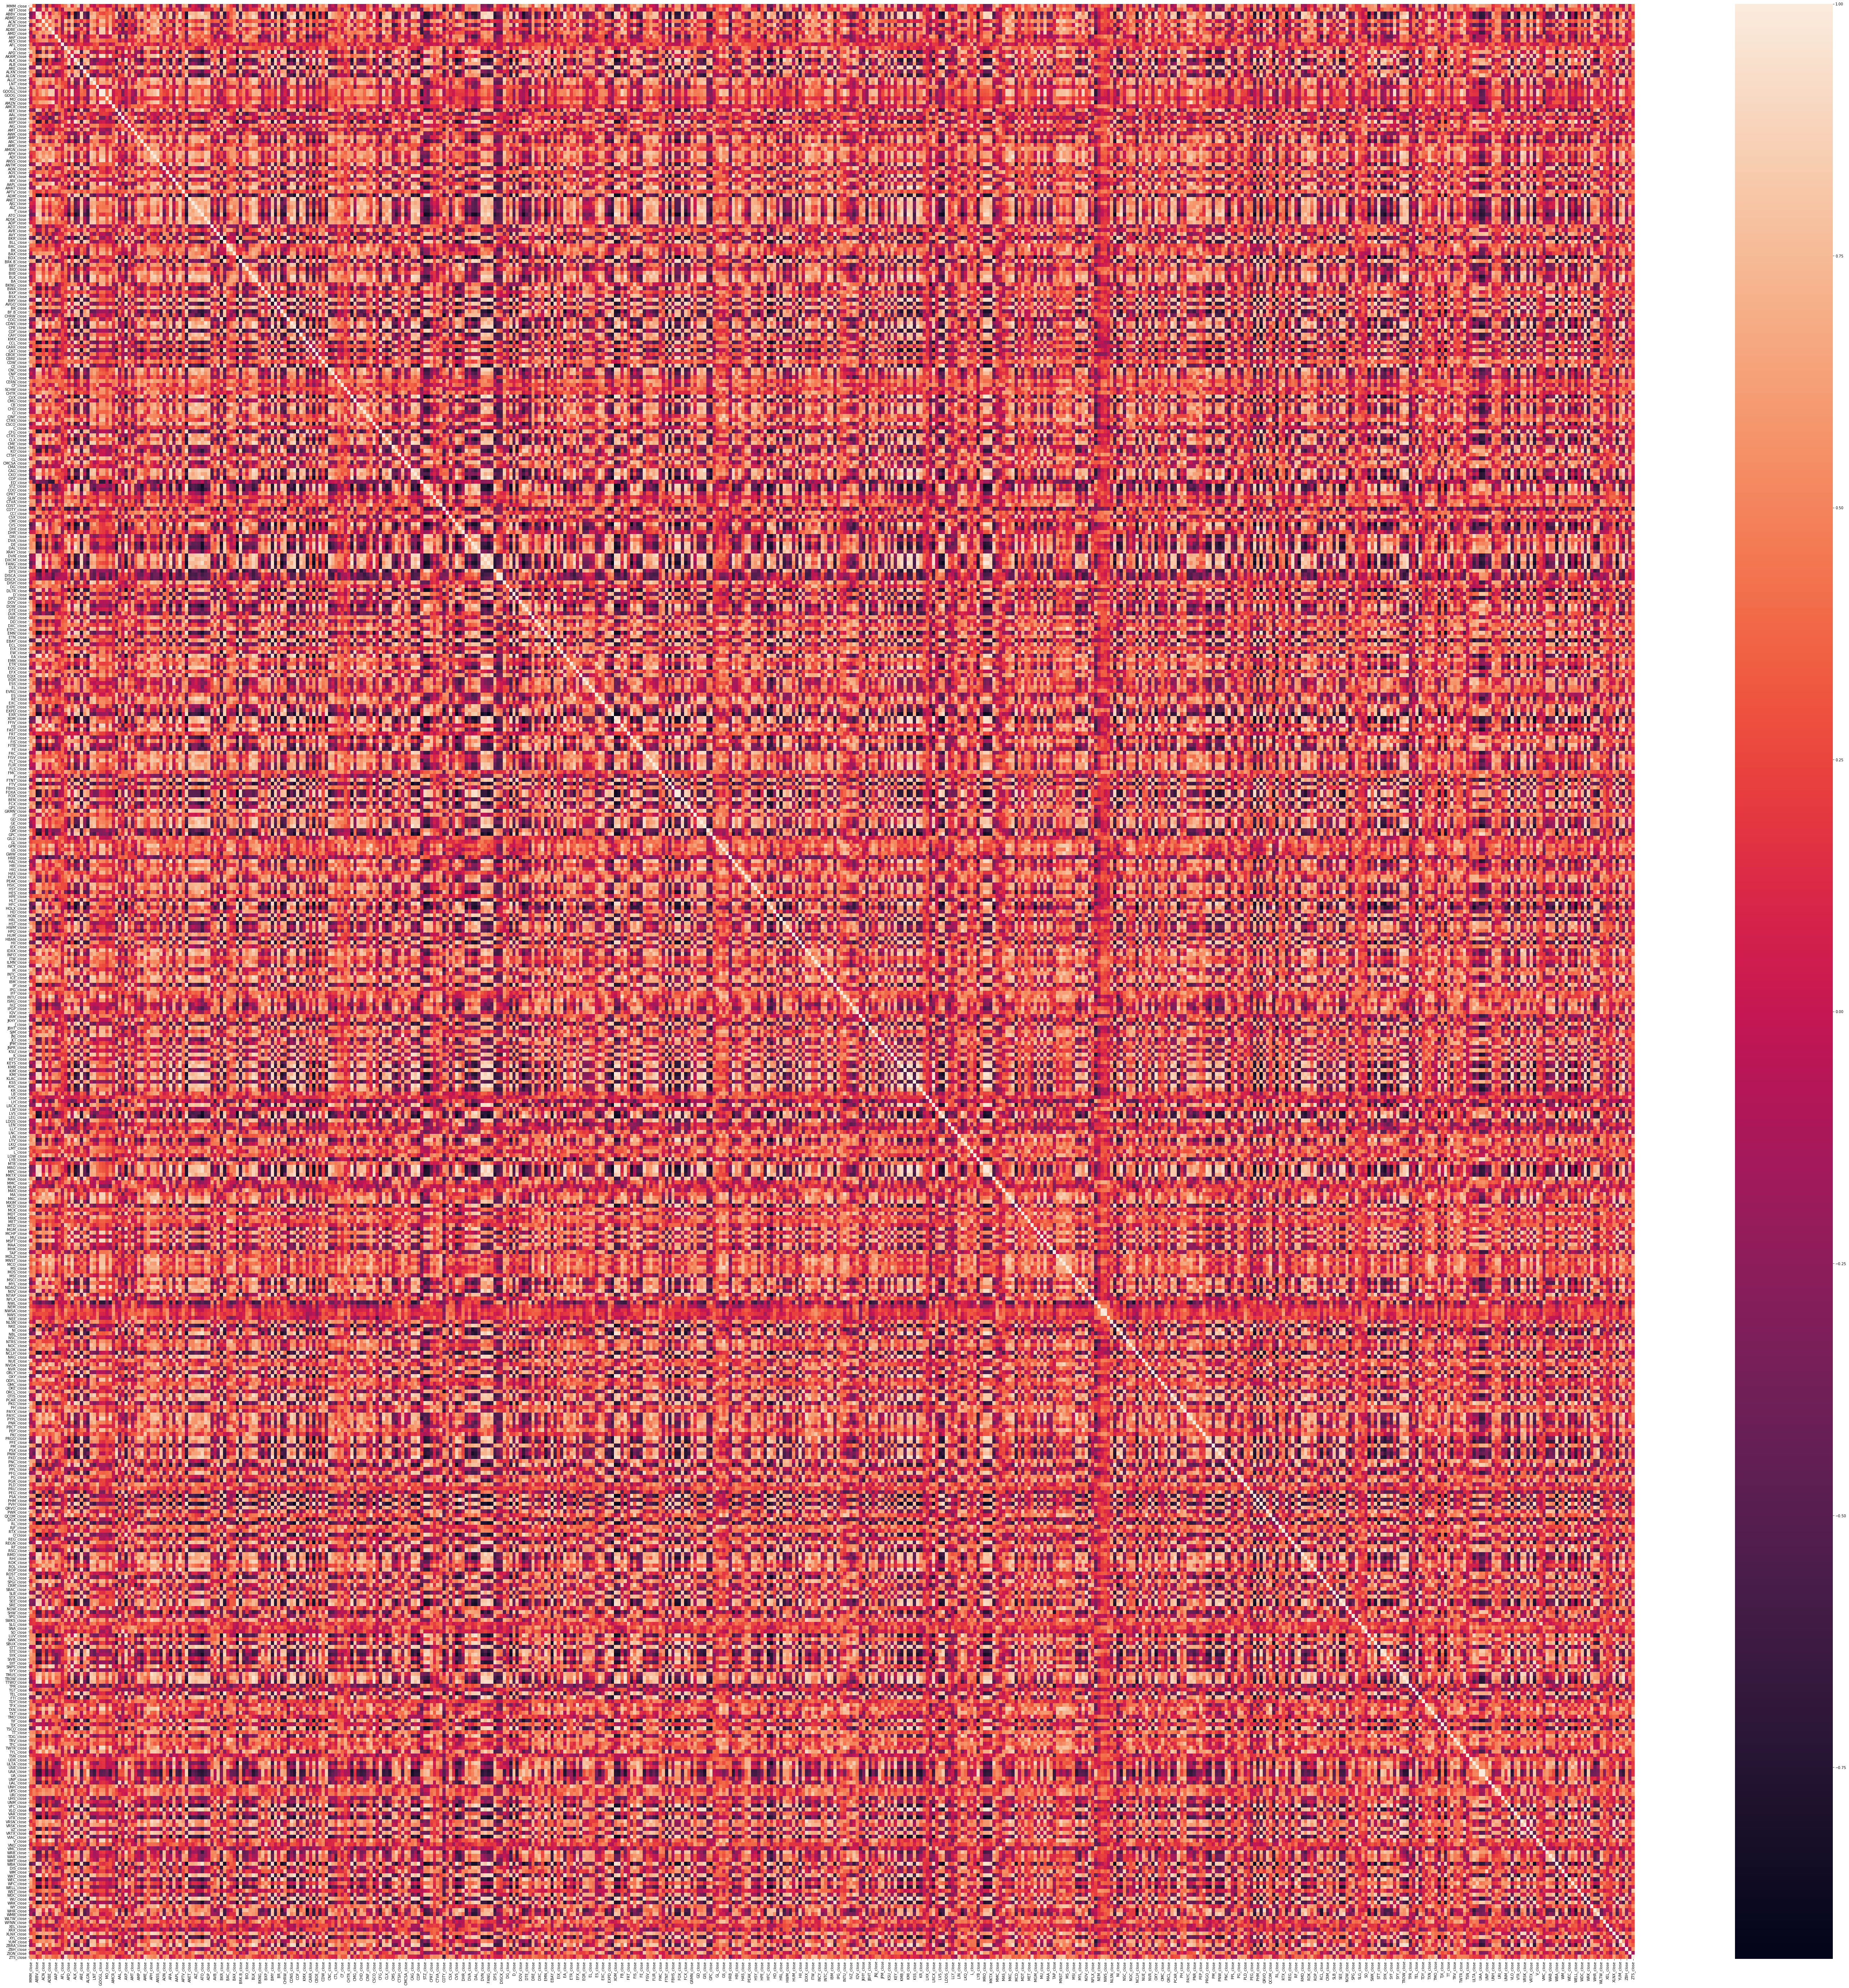

In [56]:
import seaborn as sns

plt.figure(figsize=(100,100))
sns.heatmap(interval_df[interval_df.columns[interval_df.columns.str.contains('close')]].corr())

So far, we have cut the data into intervals by computing the 'global' (here referencing the S&P500) volume * share price on a cumulative basis. We have then computed the new open, high, low, close, volume statistics for each newe 'bar'. In essence, we have forgotten about time as we normally think of it, and replaced it with a form of 'time' that measures the flow of dollars. 

Our hope in doing so would be that returns follow a more guassian or normal pattern, and are therefore more easily predictible. 

#### To do:
- Encode y data as % change in close (as we used to do) for our reward function
- Do fractional differentiation on the open, high, low, close columns for each stock
- consider volume engineered features such as fractional(ohlc, .4) * volume
- leave volume as a base feature
- compute volume * close as a comparative weight
- save those features as X
- buld TFRecordDataset for X, y

Finally, using the TFRecordDataset in another notebook begin to train models on it. 